In [35]:
import torch
import sklearn
from sklearn import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score


In [8]:
dataset = sklearn.datasets.fetch_california_housing(as_frame = True)

In [9]:
for x in dataset:
    print(x)

data
target
frame
target_names
feature_names
DESCR


In [10]:
dataset.frame.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

[0.25336868 0.23516245]
[[ 0.07746229  0.00731846  0.43914246  0.3999956  -0.17178267 -0.01464423
   0.56836442 -0.53697448]
 [ 0.22987873 -0.26078574  0.54668689  0.50184958  0.10062559  0.00262099
  -0.37401073  0.4223868 ]]


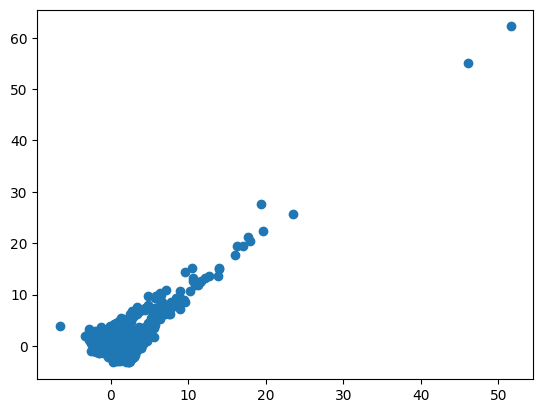

In [12]:
components = PCA(n_components = 2)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(dataset.data)
data_reduced = components.fit_transform(data_scaled)
plt.scatter(data_reduced[:,0], data_reduced[:,1])
print(components.explained_variance_ratio_)
print(components.components_)

In [13]:
#General data preparation
X_train, X_test, y_train, y_test = train_test_split(dataset.data.to_numpy(), dataset.target.to_numpy(), test_size = 0.2, random_state=1)
scaler1 = StandardScaler()
scaler1.fit(X_train)
X_train_scaled = scaler1.transform(X_train)
X_test_scaled = scaler1.transform(X_test)


In [14]:
#now let's make linear regression model using sci-kit learn

In [15]:
basic_linear_model = sklearn.linear_model.LinearRegression()
basic_linear_model.fit(X_train_scaled, y_train)
print(basic_linear_model.score(X_test_scaled,y_test), basic_linear_model.score(X_train_scaled,y_train))

0.5965968374812352 0.6083741964648377


In [16]:
#now a model with polynomial features

In [17]:
from sklearn.preprocessing import PolynomialFeatures

max_deg = 5

for i in range(2,max_deg+1):
    poly = PolynomialFeatures(i)
    poly.fit(X_train_scaled)
    X_train_poly = poly.transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)
    model = sklearn.linear_model.LinearRegression()
    model.fit(X_train_poly, y_train)
    print(model.score(X_test_poly,y_test), model.score(X_train_poly,y_train))

0.6646924483229533 0.6857011730817124
0.1581842961004103 0.7437017152032466
-135.72199593489165 0.7888074769868719
-625.2756414002147 0.8256864676958072


In [18]:
#Conclusion: linear model with polynomial features of degree = 2 gives best results. Higher degress are showing huge variance
#and overfit the data

In [19]:
#Let's now create basic linear regression model in pytorch

In [20]:
X_train_scaled = torch.Tensor(X_train_scaled)
X_test_scaled = torch.Tensor(X_test_scaled)
y_train = torch.Tensor(y_train)

w = torch.empty(8)
torch.nn.init.normal_(w)
b = torch.zeros(1)
w.requires_grad_(True)
b.requires_grad_(True) 

tensor([0.], requires_grad=True)

In [213]:
epochs = 2000
lr = 0.01

scores1 = []

for i in range(epochs):
    y_hat = torch.mv(X_train_scaled, w) + b
    
    loss = torch.mean((y_train-y_hat)**2)
    
    loss.backward()
    
    with torch.no_grad():
        w -= lr * w.grad
        b -= lr * b.grad
        
        
        
    w.grad.zero_()
    b.grad.zero_()
    
    if i%20 == 0:
        scores1.append(r2_score(y_test,(torch.mv(X_test_scaled, w) + b).detach().numpy()))
    

In [34]:

print(r2_score(y_test,(torch.mv(X_test_scaled, w) + b).detach().numpy()))
print(r2_score(y_train,(torch.mv(X_train_scaled, w) + b).detach().numpy()))

-6.27154145887566
-6.474509990020184


In [215]:
#we achieved the same results as with sklearn LinearRegression model

In [216]:
#Let's now implement the same thing, but using higher level pytorch features

In [234]:
X_train_scaled = torch.Tensor(X_train_scaled)
X_test_scaled = torch.Tensor(X_test_scaled)
y_train = torch.Tensor(y_train.reshape(-1,1))
y_test = y_test.reshape(-1,1)

model = torch.nn.Linear(8,1)

optimizer = torch.optim.Adam([model.weight, model.bias])

loss = torch.nn.MSELoss()

In [235]:
epochs = 4000

scores2 = []

for i in range(epochs):
    y_hat = model(X_train_scaled)
    
    l = loss(y_train,y_hat)
    
    l.backward()
    
    optimizer.step()
    
    optimizer.zero_grad()
    
    if i%20 == 0:
        scores2.append(r2_score(y_test, model(X_test_scaled).detach().numpy()))
    

In [236]:
print(r2_score(y_test, model(X_test_scaled).detach().numpy()))
print(r2_score(y_train, model(X_train_scaled).detach().numpy()))


0.5961881476879546
0.6062179260177909


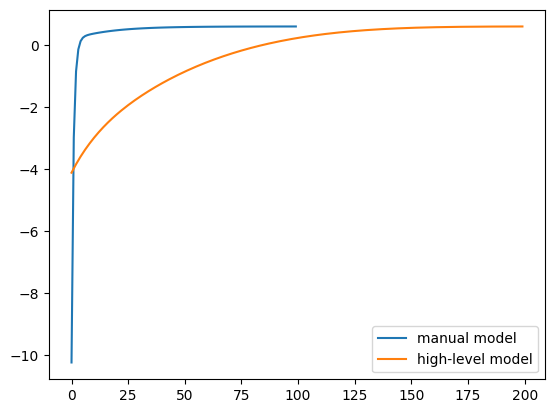

In [237]:
fig, ax = plt.subplots()
ax.plot(scores1)
ax.plot(scores2)
ax.legend(["manual model", "high-level model"])

In [238]:
#It appears that in a case as simple as that using Adam can cause more harm than good

In [253]:
X_train_scaled = torch.Tensor(X_train_scaled)
X_test_scaled = torch.Tensor(X_test_scaled)
y_train = torch.Tensor(y_train.reshape(-1,1))
y_test = y_test.reshape(-1,1)

class LinReg(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(LinReg, self).__init__()
        self.lin = torch.nn.Linear(input_size,output_size)
        
    def forward(self,X):
        return self.lin(X)

model = LinReg(8,1)

loss = torch.nn.MSELoss()

lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr)

In [255]:
epochs = 2000

for i in range(epochs):
    y_hat = model(X_train_scaled)
    
    l = loss(y_train, y_hat)
    
    l.backward()
    
    optimizer.step()
    
    optimizer.zero_grad()
    

In [254]:
print(r2_score(y_test, model(X_test_scaled).detach().numpy()))
print(r2_score(y_train, model(X_train_scaled).detach().numpy()))

-2.4566974043211074
-2.5480525880667813


In [85]:
X_train_scaled = torch.Tensor(X_train_scaled)
X_test_scaled = torch.Tensor(X_test_scaled)
y_train = torch.Tensor(y_train.reshape(-1,1))
y_test = y_test.reshape(-1,1)

class NeuralNet1(torch.nn.Module):
    def __init__(self,input_size):
        super(NeuralNet1, self).__init__()
        self.lin1 = torch.nn.Linear(input_size,10)
        self.lin2 = torch.nn.Linear(10,5)
        self.lin3 = torch.nn.Linear(5,1)
        self.activation1 = torch.nn.ReLU()
        self.activation2 = torch.nn.ReLU()
    
    def forward(self, X):
        X = self.lin1(X)
        X = self.activation1(X)
        X = self.lin2(X)
        X = self.activation2(X)
        X = self.lin3(X)
        return X
    
model = NeuralNet1(8)    
    
optimizer = torch.optim.Adam(model.parameters())

loss = torch.nn.MSELoss()

In [88]:
epochs = 10000

for i in range(epochs):
    y_hat = model(X_train_scaled)
    
    l = loss(y_train, y_hat)
    
    l.backward()
    
    optimizer.step()
    
    optimizer.zero_grad()
    


In [89]:
print(r2_score(y_test, model(X_test_scaled).detach().numpy()))
print(r2_score(y_train, model(X_train_scaled).detach().numpy()))

0.7898999767565872
0.8075847446297219


In [61]:
#Let's go back for a moment to linear regression to try it with regularization

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset.data.to_numpy(), dataset.target.to_numpy(), test_size = 0.2, random_state=1)
scaler1 = StandardScaler()
scaler1.fit(X_train)
X_train_scaled = scaler1.transform(X_train)
X_test_scaled = scaler1.transform(X_test)

In [91]:


from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

max_deg = 3

reg_params = np.arange(0,2.5,0.5)

for i in range(2,max_deg+1):
    for j in reg_params:
        poly = PolynomialFeatures(i)
        poly.fit(X_train_scaled)
        X_train_poly = poly.transform(X_train_scaled)
        X_test_poly = poly.transform(X_test_scaled)
        modelr = Ridge(alpha = j*(2**i))
        modelr.fit(X_train_poly, y_train)
        print(f"Degree: {i}, regularization parameter: {j*(2**i)}, test score: {modelr.score(X_test_poly,y_test):.3f}, train score: {modelr.score(X_train_poly,y_train):.3f}")

Degree: 2, regularization parameter: 0.0, test score: 0.665, train score: 0.686
Degree: 2, regularization parameter: 2.0, test score: 0.666, train score: 0.686
Degree: 2, regularization parameter: 4.0, test score: 0.666, train score: 0.686
Degree: 2, regularization parameter: 6.0, test score: 0.667, train score: 0.686
Degree: 2, regularization parameter: 8.0, test score: 0.668, train score: 0.685
Degree: 3, regularization parameter: 0.0, test score: 0.158, train score: 0.744
Degree: 3, regularization parameter: 4.0, test score: 0.663, train score: 0.740
Degree: 3, regularization parameter: 8.0, test score: 0.709, train score: 0.737
Degree: 3, regularization parameter: 12.0, test score: 0.716, train score: 0.734
Degree: 3, regularization parameter: 16.0, test score: 0.716, train score: 0.732


In [92]:
# the best I managed to achieve is 0.716/0.734 for degree 3 and alpha = 12

In [149]:
X_train, X_test, y_train, y_test = train_test_split(dataset.data.to_numpy(), dataset.target.to_numpy(), test_size = 0.2, random_state=1)
scaler1 = StandardScaler()
scaler1.fit(X_train)
X_train_scaled = scaler1.transform(X_train)
X_test_scaled = scaler1.transform(X_test)

In [151]:
from sklearn.linear_model import SGDRegressor

max_deg = 4

for i in range(1,max_deg+1):
    
    poly = PolynomialFeatures(i)
    poly.fit(X_train_scaled)
    X_train_poly = poly.transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)
    
    modelsgd = SGDRegressor(alpha = 0, max_iter = 10000, n_iter_no_change = 500, tol=0.00001, eta0 = 0.001)
    modelsgd.fit(X_train_poly, y_train)
    print(modelsgd.score(X_test_poly, y_test), modelsgd.score(X_train_poly, y_train))
    print(modelsgd.n_iter_)


0.596560582668516 0.608364576801149
945
-3.268659770490942e+22 -1.0003095381187163e+26
958
-1.6561914361381632e+29 -2.727706235438271e+34
640
-2.3437366165741877e+34 -3.0647453623256107e+41
692


In [152]:
#SGD doesn't work 

In [169]:
X_train_scaled = torch.Tensor(X_train_scaled)
X_test_scaled = torch.Tensor(X_test_scaled)
y_train = torch.Tensor(y_train.reshape(-1,1))
y_test = y_test.reshape(-1,1)

class NeuralNet2(torch.nn.Module):
    def __init__(self,input_size):
        super(NeuralNet2, self).__init__()
        self.lin1 = torch.nn.Linear(input_size,16)
        self.lin2 = torch.nn.Linear(16,8)
        self.lin3 = torch.nn.Linear(8,1)
        self.activation1 = torch.nn.ReLU()
        self.activation2 = torch.nn.ReLU()
    
    def forward(self, X):
        X = self.lin1(X)
        X = self.activation1(X)
        X = self.lin2(X)
        X = self.activation2(X)
        X = self.lin3(X)
        return X
    
modelnn2 = NeuralNet2(8)    
    
optimizer = torch.optim.Adam(modelnn2.parameters())

loss = torch.nn.MSELoss()

In [172]:
epochs = 10000

for i in range(epochs):
    y_hat = modelnn2(X_train_scaled)
    
    l = loss(y_train, y_hat)
    
    l.backward()
    
    optimizer.step()
    
    optimizer.zero_grad()
    

In [173]:
print(r2_score(y_test, modelnn2(X_test_scaled).detach().numpy()))
print(r2_score(y_train, modelnn2(X_train_scaled).detach().numpy()))

0.7924965080297752
0.8221002517623216


In [174]:
# 30k epochs, 14x7x1
#0.8033538446671039
#0.8286151912266871

# 30k epochs, 16x8x1    
#0.7924965080297752
#0.8221002517623216

#second model too big

In [187]:
X_train_scaled = torch.Tensor(X_train_scaled)
X_test_scaled = torch.Tensor(X_test_scaled)
y_train = torch.Tensor(y_train.reshape(-1,1))
y_test = y_test.reshape(-1,1)

class NeuralNet3(torch.nn.Module):
    def __init__(self,input_size):
        super(NeuralNet3, self).__init__()
        self.lin1 = torch.nn.Linear(input_size,10)
        self.lin2 = torch.nn.Linear(10,5)
        self.lin3 = torch.nn.Linear(5,5)
        self.lin4 = torch.nn.Linear(5,1)
        self.activation1 = torch.nn.ReLU()
        self.activation2 = torch.nn.ReLU()
        self.activation3 = torch.nn.ReLU()
    
    def forward(self, X):
        X = self.lin1(X)
        X = self.activation1(X)
        X = self.lin2(X)
        X = self.activation2(X)
        X = self.lin3(X)
        X = self.activation3(X)
        X = self.lin4(X)
        return X
    
modelnn3 = NeuralNet3(8)    
    
optimizer = torch.optim.Adam(modelnn3.parameters())

loss = torch.nn.MSELoss()

In [188]:
epochs = 30000

for i in range(epochs):
    y_hat = modelnn3(X_train_scaled)
    
    l = loss(y_train, y_hat)
    
    l.backward()
    
    optimizer.step()
    
    optimizer.zero_grad()
    

In [189]:
print(r2_score(y_test, modelnn3(X_test_scaled).detach().numpy()))
print(r2_score(y_train, modelnn3(X_train_scaled).detach().numpy()))

0.7764227126069352
0.8038641640466986


In [ ]:
# 30k epochs, 10x5x3x1
#0.7826017643319172
#0.8037494784977373

#even worse for 10x5x5x1

#Conclusion: depth 3 seems good and corresponds to deg 3 of polynomial regression being the best